In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\19ebe\AppData\Local\Temp\ipykernel_43552\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

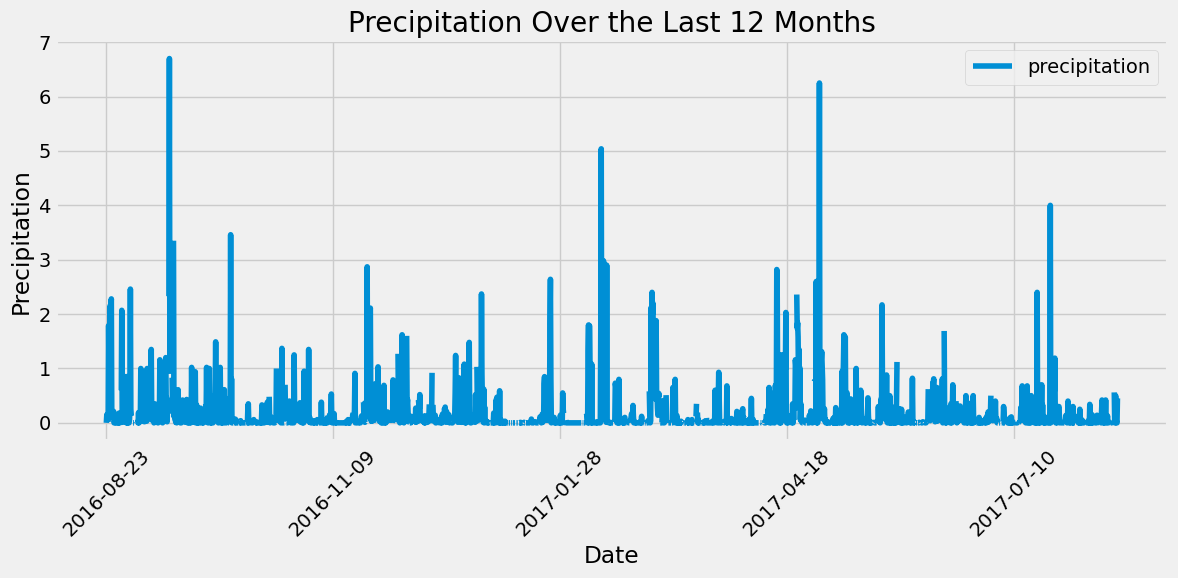

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(2017,8,23)

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.set_index('date', inplace=True)
precip_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Over the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the stations and their counts
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Find the most active station ID
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]

# Display the results
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


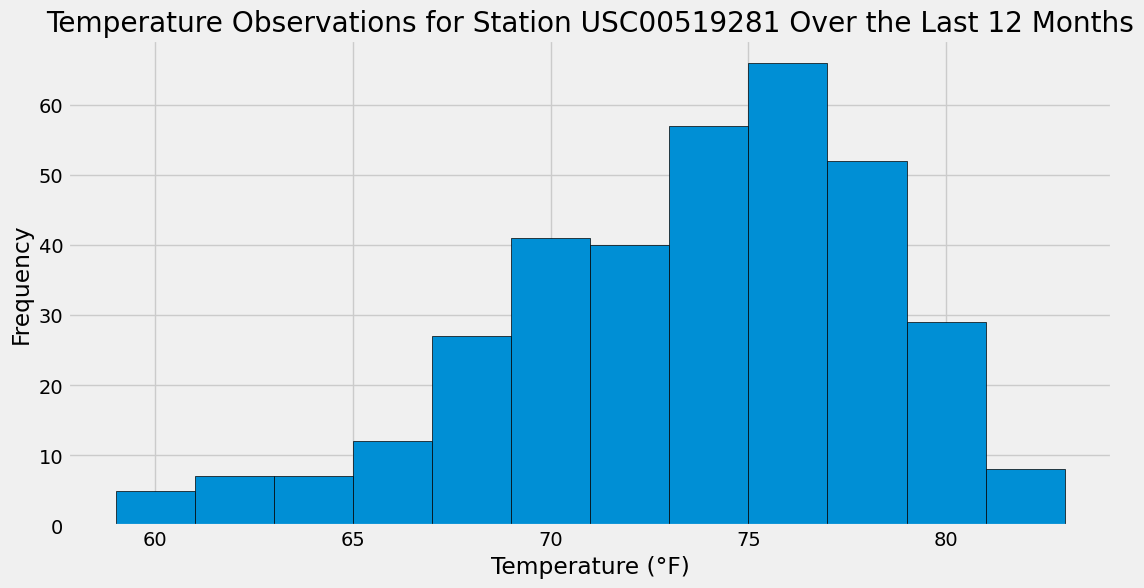

In [15]:
# Find the most active station ID
most_active_station = active_stations[0][0]

# Calculate the date one year from the last date in the dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Plot the results as a histogram
plt.figure(figsize=(12, 6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station} Over the Last 12 Months')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()